Muss noch vertexten. 
Dieses Notebook verwendet die Daten aus DATASET. 

In [17]:
import os
import glob
import cv2 as cv
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib


--- Classification Report (Unweighted) ---
              precision    recall  f1-score   support

      defect       0.99      1.00      0.99       692
          ok       0.99      0.96      0.98       169

    accuracy                           0.99       861
   macro avg       0.99      0.98      0.99       861
weighted avg       0.99      0.99      0.99       861



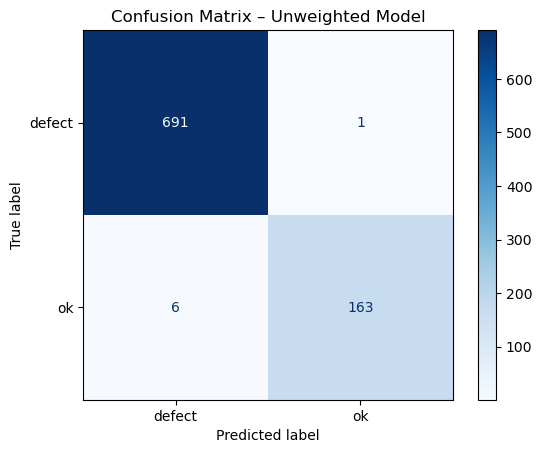


--- Classification Report (Weighted) ---
              precision    recall  f1-score   support

      defect       1.00      1.00      1.00       692
          ok       1.00      0.98      0.99       169

    accuracy                           1.00       861
   macro avg       1.00      0.99      0.99       861
weighted avg       1.00      1.00      1.00       861



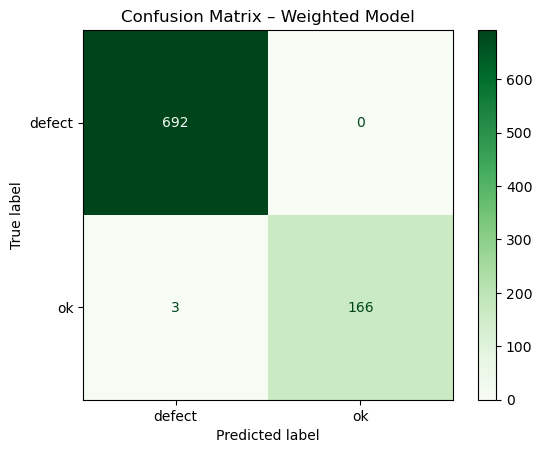


Weighted model saved as syringe_model_dataset_weighted.pkl


In [25]:
# train_syringe_modelAH_RF.ipynb




# --- Paths ---
base_path = "dataset"
ok_folder = "ok"
defect_folders = ["1_leer", "5_ObjektInSpritze", "6_kleineBlase", "7_grosseBlase", "8_Stoerung"]

# --- Feature extraction ---
def extract_features(image_path):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv.resize(img, (64, 64))
    blur = cv.GaussianBlur(img, (5, 5), 0)
    edges = cv.Canny(blur, 30, 100)
    hist = cv.calcHist([img], [0], None, [16], [0, 256]).flatten()
    return np.concatenate([edges.flatten(), hist])

# --- Load images ---
features = []
labels = []

ok_path = os.path.join(base_path, ok_folder)
for filepath in glob.glob(os.path.join(ok_path, "*.jpg")):
    f = extract_features(filepath)
    if f is not None:
        features.append(f)
        labels.append("ok")

for defect_subfolder in defect_folders:
    defect_path = os.path.join(base_path, defect_subfolder)
    for filepath in glob.glob(os.path.join(defect_path, "*.jpg")):
        f = extract_features(filepath)
        if f is not None:
            features.append(f)
            labels.append("defect")

X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Unweighted model ---
clf_unweighted = RandomForestClassifier(n_estimators=100, random_state=42)
clf_unweighted.fit(X_train, y_train)
y_pred_unweighted = clf_unweighted.predict(X_test)

print("\n--- Classification Report (Unweighted) ---")
print(classification_report(y_test, y_pred_unweighted, target_names=["defect", "ok"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_unweighted, display_labels=["defect", "ok"], cmap="Blues")
plt.title("Confusion Matrix – Unweighted Model")
plt.grid(False)
plt.show()

# --- Weighted model ---
clf_weighted = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf_weighted.fit(X_train, y_train)
y_pred_weighted = clf_weighted.predict(X_test)

print("\n--- Classification Report (Weighted) ---")
print(classification_report(y_test, y_pred_weighted, target_names=["defect", "ok"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_weighted, display_labels=["defect", "ok"], cmap="Greens")
plt.title("Confusion Matrix – Weighted Model")
plt.grid(False)
plt.show()

# --- Optional: Save best model ---
joblib.dump(clf_weighted, "syringe_model_dataset_weighted.pkl")
print("\nWeighted model saved as syringe_model_dataset_weighted.pkl")


predictions


--- Einzelne Vorhersagen für Testdaten ---
Bild 1: ECHT = ok | VORHERSAGE = ok
Bild 2: ECHT = defect | VORHERSAGE = defect
Bild 3: ECHT = defect | VORHERSAGE = defect
Bild 4: ECHT = defect | VORHERSAGE = defect
Bild 5: ECHT = defect | VORHERSAGE = defect
Bild 6: ECHT = defect | VORHERSAGE = defect
Bild 7: ECHT = defect | VORHERSAGE = defect
Bild 8: ECHT = defect | VORHERSAGE = defect
Bild 9: ECHT = defect | VORHERSAGE = defect
Bild 10: ECHT = defect | VORHERSAGE = defect
Bild 11: ECHT = defect | VORHERSAGE = defect
Bild 12: ECHT = ok | VORHERSAGE = ok
Bild 13: ECHT = defect | VORHERSAGE = defect
Bild 14: ECHT = defect | VORHERSAGE = defect
Bild 15: ECHT = defect | VORHERSAGE = defect
Bild 16: ECHT = defect | VORHERSAGE = defect
Bild 17: ECHT = defect | VORHERSAGE = defect
Bild 18: ECHT = ok | VORHERSAGE = ok
Bild 19: ECHT = defect | VORHERSAGE = defect
Bild 20: ECHT = defect | VORHERSAGE = defect
Bild 21: ECHT = defect | VORHERSAGE = defect
Bild 22: ECHT = defect | VORHERSAGE = defect

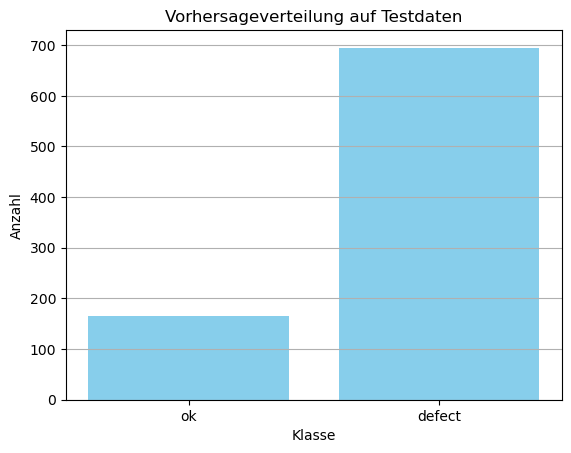

In [26]:
# --- Vorhersage für Testdaten ---
y_pred_test = clf_weighted.predict(X_test)

# Einzelne Vorhersagen anzeigen
print("\n--- Einzelne Vorhersagen für Testdaten ---")
for i, (true_label, predicted_label) in enumerate(zip(y_test, y_pred_test)):
    print(f"Bild {i+1}: ECHT = {true_label} | VORHERSAGE = {predicted_label}")

# Optional: Visualisierung als Balkendiagramm der Gesamtverteilung
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(y_pred_test)
plt.bar(counter.keys(), counter.values(), color='skyblue')
plt.title("Vorhersageverteilung auf Testdaten")
plt.ylabel("Anzahl")
plt.xlabel("Klasse")
plt.grid(axis='y')
plt.show()


# Funktionierendes Modell

### Explanation of Key Steps

1. **Loading and Labeling**
   - We load original “ok” images from `dataset/ok` and “defect” images from each defect subfolder.
   - We also gather all demonstration images (`demo_ok_files`, `demo_defect_files`).

2. **Feature Extraction: ORB + LBP**
   - ORB outputs up to 100 keypoint descriptors per 64×64 grayscale image (a 3200-dimensional vector).
   - LBP histogram yields a 256-dimensional histogram (normalized).
   - The final feature length is **3456** per image (3200 ORB + 256 LBP).

3. **Data Augmentation for “ok” Class**
   - We take each demonstration “ok” image and generate 3 random augmentations (flips + random brightness/contrast).
   - This effectively increases the number of “ok” samples to reduce class imbalance.

4. **Holdout Split for Demonstration Set**
   - We reserve 20% of both `demo_ok_files` and `demo_defect_files` as a final holdout set (they are never used in training).
   - The remaining demonstration images are used in augmentation/training.

5. **Train/Test Split**
   - We combine original dataset images and augmented images, then split 80/20 into `X_train` / `X_test`.
   - The holdout files are kept separately to measure real “live” performance.

6. **Random Forest Training**
   - We train on `X_train`, `y_train` with `class_weight="balanced"`.

7. **Evaluation on Combined Test Set**
   - We print a classification report + confusion matrix on `X_test` (20% of the combined training data).

8. **Evaluation on Demonstration Holdout**
   - We compute `y_hold_pred` on `X_hold` (the 20% of demo images reserved).
   - We generate a classification report + confusion matrix specifically for those holdout images. This shows how the model truly generalizes to demonstration conditions.

9. **Predictions on All Demonstration Images**
   - We loop over all `demo_ok_files` + `demo_defect_files` again, extract features, and print “ok” or “defect” for each file. This gives you a final summary of predictions on every demonstration image.

---

With this pipeline, your model:
- Trains on a **balanced, augmented** set of “ok” vs. “defect” syringes  
- Uses **ORB+LBP** (rotation-invariant) feature vectors  
- Evaluates on both a held-out subset of the full dataset and a held-out subset of demonstration images  
- Prints per-image predictions on all demonstration images  

Because we now include demonstration images in the training/augmentation (minus a small holdout set), the forest should learn to handle exactly the same conditions (lighting, background, orientation) that your webcam will produce.

If you run this full script, you should see a much better mix of “ok” and “defect” predictions rather than classifying every “ok” as “defect.” You can adjust the number of augmentations (now 3× per demo “ok”) or increase it further if the holdout performance is still too low.  


Total training samples: (6249, 3456) Labels distribution: (array([0, 1]), array([2733, 3516], dtype=int64))
After augmentation, training distribution: (array([0, 1]), array([4287, 3516], dtype=int64))
Train set distribution: (array([0, 1]), array([3429, 2813], dtype=int64))
Test set distribution: (array([0, 1]), array([858, 703], dtype=int64))

Classification Report on Combined Test Split
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       858
           1       0.94      0.95      0.95       703

    accuracy                           0.95      1561
   macro avg       0.95      0.95      0.95      1561
weighted avg       0.95      0.95      0.95      1561



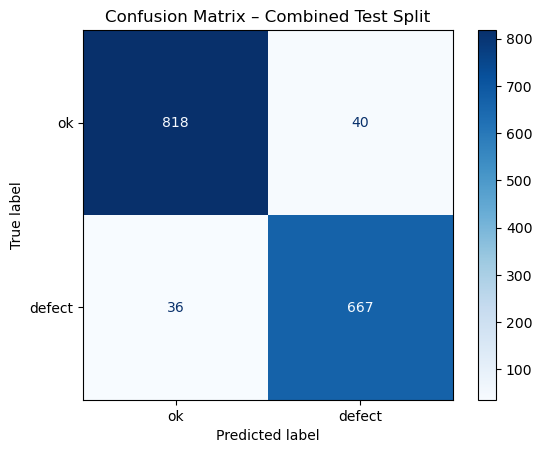


Model saved as syringe_rf_orb_lbp_augmented.pkl

--- Classification Report on Demonstration Holdout ---
              precision    recall  f1-score   support

          ok       1.00      0.81      0.89       130
      defect       0.83      1.00      0.90       118

    accuracy                           0.90       248
   macro avg       0.91      0.90      0.90       248
weighted avg       0.92      0.90      0.90       248



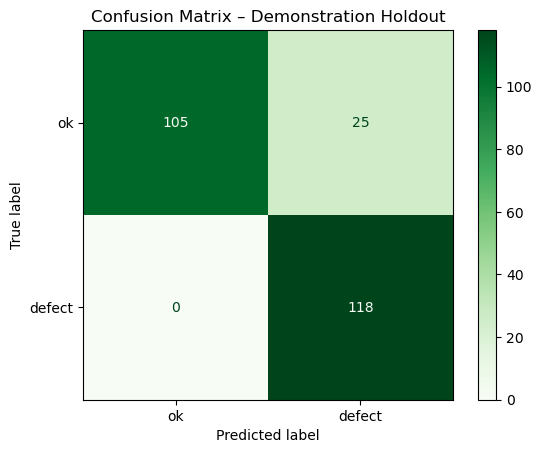


--- Predictions on ALL Demonstration Images ---
syringe_0_20250531_171832.jpg -> ok
syringe_100_20250531_171835.jpg -> ok
syringe_101_20250531_171835.jpg -> defect
syringe_102_20250531_171835.jpg -> defect
syringe_103_20250531_171835.jpg -> ok
syringe_104_20250531_171835.jpg -> ok
syringe_105_20250531_171835.jpg -> defect
syringe_106_20250531_171835.jpg -> defect
syringe_107_20250531_171835.jpg -> defect
syringe_108_20250531_171835.jpg -> ok
syringe_109_20250531_171835.jpg -> defect
syringe_10_20250531_171832.jpg -> ok
syringe_110_20250531_171835.jpg -> ok
syringe_111_20250531_171835.jpg -> ok
syringe_112_20250531_171835.jpg -> ok
syringe_113_20250531_171835.jpg -> ok
syringe_114_20250531_171835.jpg -> ok
syringe_115_20250531_171836.jpg -> ok
syringe_116_20250531_171836.jpg -> ok
syringe_117_20250531_171836.jpg -> ok
syringe_118_20250531_171836.jpg -> ok
syringe_119_20250531_171836.jpg -> ok
syringe_11_20250531_171832.jpg -> ok
syringe_120_20250531_171836.jpg -> ok
syringe_121_2025053

In [38]:
import os
import glob
import random
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

# 1) Paths
dataset_ok = "dataset/ok"
dataset_defect_folders = [
    "dataset/1_leer",
    "dataset/5_ObjektInSpritze",
    "dataset/6_kleineBlase",
    "dataset/7_grosseBlase",
    "dataset/8_Stoerung"
]

demo_ok = "detected_syringes"
demo_defect = "detected_syringes_with_bubbles"

# 2) ORB + LBP extractor
orb = cv2.ORB_create(nfeatures=100)
LBP_POINTS = 8
LBP_RADIUS = 1

def extract_features(image):
    """
    Input: grayscale or color image array
    Output: ORB (3200 dims) + LBP (256 dims) = 3456-dim feature vector
    """
    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (64, 64))
    
    # ORB
    kp, des = orb.detectAndCompute(gray, None)
    if des is None:
        des = np.zeros((0, 32), dtype=np.uint8)
    # Pad or truncate to exactly 100 descriptors
    if des.shape[0] < 100:
        pad_count = 100 - des.shape[0]
        des = np.vstack([des, np.zeros((pad_count, 32), dtype=np.uint8)])
    elif des.shape[0] > 100:
        des = des[:100]
    orb_feat = des.flatten().astype(np.float32)  # 100×32 = 3200 dims
    
    # LBP
    lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(257), range=(0, 256))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-6)  # normalize to sum=1
    
    return np.concatenate([orb_feat, hist])


def random_augment_ok_image(img):
    """Apply random flip, brightness/contrast changes to simulate demo conditions."""
    # Random flip
    if random.choice([True, False]):
        img = cv2.flip(img, random.choice([0, 1]))
    # Random brightness/contrast
    alpha = random.uniform(0.8, 1.2)   # contrast factor
    beta = random.uniform(-30, 30)     # brightness offset
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img

# 3) Load and label original dataset images
X = []
y = []

# a) original "ok" images
orig_ok_files = glob.glob(os.path.join(dataset_ok, "*.jpg"))
for fp in orig_ok_files:
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    feat = extract_features(img)
    X.append(feat)
    y.append(0)  # 0 = ok

# b) original "defect" images
for folder in dataset_defect_folders:
    for fp in glob.glob(os.path.join(folder, "*.jpg")):
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        feat = extract_features(img)
        X.append(feat)
        y.append(1)  # 1 = defect

# c) DEMO images for augmentation (only "ok", not used in holdout)
demo_ok_files = glob.glob(os.path.join(demo_ok, "*.jpg"))
for fp in demo_ok_files:
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    # Generate 3 random augmentations per demo "ok" image
    for _ in range(3):
        img_aug = random_augment_ok_image(img)
        feat = extract_features(img_aug)
        X.append(feat)
        y.append(0)

# d) (Optional) Demo "defect" augmentation could also be used here if needed.

# Convert to arrays
X = np.array(X)
y = np.array(y)
print("Total training samples:", X.shape, "Labels distribution:", np.unique(y, return_counts=True))

# 4) Hold out 20% of original demo images for final testing
#    We will remove a subset of demo_ok and demo_defect from training, then evaluate separately.
demo_defect_files = glob.glob(os.path.join(demo_defect, "*.jpg"))

# Split demo images into train/demo_holdout for final evaluation
demo_ok_train, demo_ok_hold = train_test_split(
    demo_ok_files, test_size=0.2, random_state=42
)
demo_defect_train, demo_defect_hold = train_test_split(
    demo_defect_files, test_size=0.2, random_state=42
)

# Remove holdout images from augmentation/training set if they were included
# (We only augmented based on demo_ok, so holdout “ok” must be excluded)
holdout_ok_feats = []
holdout_ok_labels = []
for fp in demo_ok_hold:
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    holdout_ok_feats.append(extract_features(img))
    holdout_ok_labels.append(0)

holdout_defect_feats = []
holdout_defect_labels = []
for fp in demo_defect_hold:
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    holdout_defect_feats.append(extract_features(img))
    holdout_defect_labels.append(1)

# Now augment again only on demo_ok_train
for fp in demo_ok_train:
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    for _ in range(3):
        img_aug = random_augment_ok_image(img)
        feat = extract_features(img_aug)
        X = np.vstack([X, feat])
        y = np.append(y, 0)

print("After augmentation, training distribution:", np.unique(y, return_counts=True))

# 5) Split original combined dataset into train/test (excluding holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set distribution:", np.unique(y_train, return_counts=True))
print("Test set distribution:", np.unique(y_test, return_counts=True))

# 6) Train Random Forest with balanced class weights
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Evaluate on X_test (from combined dataset)
y_pred_test = clf.predict(X_test)
print("\nClassification Report on Combined Test Split")
print(classification_report(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=["ok", "defect"], cmap="Blues")
plt.title("Confusion Matrix – Combined Test Split")
plt.grid(False)
plt.show()

# 7) Save the new model
model_filename = "syringe_rf_orb_lbp_augmented.pkl"
joblib.dump(clf, model_filename)
print(f"\nModel saved as {model_filename}")

# 8) Evaluate on holdout demonstration images
X_hold = np.array(holdout_ok_feats + holdout_defect_feats)
y_hold = np.array(holdout_ok_labels + holdout_defect_labels)

y_hold_pred = clf.predict(X_hold)
print("\n--- Classification Report on Demonstration Holdout ---")
print(classification_report(y_hold, y_hold_pred, target_names=["ok", "defect"]))
ConfusionMatrixDisplay.from_predictions(y_hold, y_hold_pred, display_labels=["ok", "defect"], cmap="Greens")
plt.title("Confusion Matrix – Demonstration Holdout")
plt.grid(False)
plt.show()

# 9) Print individual predictions on ALL demonstration images
all_demo_files = demo_ok_files + demo_defect_files
print("\n--- Predictions on ALL Demonstration Images ---")
predictions_all = clf.predict(np.array(
    [extract_features(cv2.imread(fp, cv2.IMREAD_GRAYSCALE)) for fp in all_demo_files]
))
for fp, p in zip(all_demo_files, predictions_all):
    label = "ok" if p == 0 else "defect"
    print(f"{os.path.basename(fp)} -> {label}")
